In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from torch import nn, optim
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28,28), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))
              

In [4]:
train_dataset= dsets.MNIST( root='./data', train=True, download=True, transform= transforms.ToTensor())
validation_dataset= dsets.MNIST( root='./data', train=False, download=True, transform= transforms.ToTensor())

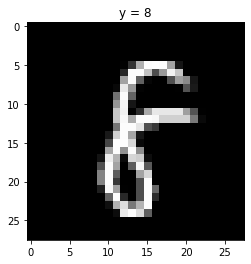

In [5]:
show_data(train_dataset[456])

In [6]:
class net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.relu(self.linear1(x)))
        x = self.bn2(torch.relu(self.linear2(x)))
        x = self.linear3(x)
        return x

        

In [7]:
in_dim= 28*28
hidden1=50
hidden2=50
out_dim=10


In [32]:
def train_model( model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i=0
    useful_data= {'training_loss':[], 'validation_accuracy':[]}
    for epochs in range(epochs):
        for i, (x,y) in enumerate(train_loader):
            model.train()
            z= model(x.view(-1, 28*28))
            loss= criterion(z, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            useful_data['training_loss'].append(loss.data.item())
                
        correct=0
        for x_test, y_test in validation_loader:
            model.eval()
            z= model( x_test.view(-1, 28*28))
            _,label= torch.max(z, 1)
            correct+= (label == y_test).sum().item()
        accuracy= 100*(correct/len(validation_dataset))
        useful_data['validation_accuracy'].append(accuracy)
        
    return useful_data
  
        
                
            

In [12]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28*28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x_test, y_test in validation_loader:
            model.eval()
            yhat = model(x_test.view(-1, 28*28))
            _, label = torch.max(yhat, 1)
            correct += (label == y_test).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

In [8]:
train_loader= DataLoader( dataset= train_dataset, batch_size=2000, shuffle= True)
validation_loader= DataLoader( dataset= validation_dataset, batch_size=5000, shuffle= False)

In [13]:
model= net(in_dim, hidden1, hidden2, out_dim)
criterion= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
training_results= train(model, criterion, train_loader, validation_loader, optimizer, epochs=15)

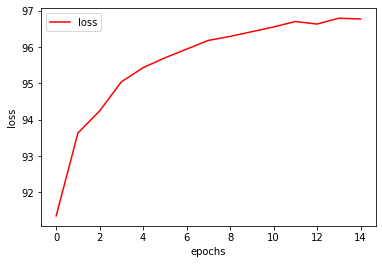

In [14]:
plt.plot(training_results['validation_accuracy'],'r', label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
path= './arnav_net.pth'
torch.save(model.state_dict(), path) 

In [9]:
model=net(in_dim, hidden1, hidden2, out_dim)
model.load_state_dict(torch.load('./arnav_net.pth'))
model.eval()

net(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
correct=0
for x_test, y_test in validation_loader:
    z= model(x_test.view(-1,28*28))
    _,label= torch.max(z.data, 1)
    correct+= (label == y_test).sum().item()
accuracy= correct/ len(validation_dataset)
print(accuracy)
    

0.9677


In [18]:

from tkinter import *
import tkinter as tk
import win32gui
from PIL import ImageGrab, Image
import numpy as np
image_size=28
def predict_digit(img):
    #resize image to 28x28 pixels
    composed= transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
    #reshaping to support our model input and normalizing
    #predicting the class
    img= composed(img)
    res= model(img.view(-1, 28*28))
    _,label= torch.max(res, 1)
    return label
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        # Creating elements
        self.canvas = tk.Canvas(self, width=300, height=300, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        #self.canvas.bind("<Motion>", self.start_pos)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    def clear_all(self):
        self.canvas.delete("all")
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit  = predict_digit(im)
        self.label.configure(text= str(digit))
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=8
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')
app = App()
mainloop()
